In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [3]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import requests

# 下载并加载BLIP处理器和模型
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Define Data Loader

In [4]:
# Showing one example
# TODO: Add VSNR for cosine similarity
data_loader = loaders.DataLoader(data_source = "qa", logger=logger)
df_table = data_loader.load_dialogue_df()

#k = 5
#data_loader.showing_example(k)
#data_loader.show_clip_similarity(k, df_table, model, preprocess)

# Define OOD Categories below

In [5]:
import gensim.downloader as api
wv_model = api.load("word2vec-google-news-300")

ModuleNotFoundError: No module named 'gensim'

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
nltk.download('wordnet')


lemmatizer = WordNetLemmatizer()
new_supercategories = ['person', 
                       'animal', 
                       'vehicle', 
                       'city', 
                       'fashion', 
                       'sports', 
                       'tableware', 
                       'food', 
                       'furniture', 
                       'electricity', 
                       'appliance', 
                       'bedroom']
lemmatized_supercategories = [lemmatizer.lemmatize(word) for word in new_supercategories]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WFYIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
cosine_similarity_list = []
for category_a in new_supercategories:
    cosine_sim_current = 0
    for category_b in new_supercategories:
        text_tokens_a = wv_model[category_a]
        text_tokens_b = wv_model[category_b]
        cosine_sim_current += np.dot(text_tokens_a, text_tokens_b) / (np.linalg.norm(text_tokens_a) * np.linalg.norm(text_tokens_b))
    print(f"Cosine similarity for {category_a} is: {cosine_sim_current - 1}")
    cosine_similarity_list.append(cosine_sim_current - 1)

Cosine similarity for person is: 1.4143455289304256
Cosine similarity for animal is: 1.6354316156357527
Cosine similarity for vehicle is: 1.8234858587384224
Cosine similarity for city is: 1.3873335495591164
Cosine similarity for fashion is: 1.6184211000800133
Cosine similarity for sports is: 1.158731622621417
Cosine similarity for tableware is: 2.077450927346945
Cosine similarity for food is: 2.232462417334318
Cosine similarity for furniture is: 2.7513381876051426
Cosine similarity for electricity is: 1.6236049849539995
Cosine similarity for appliance is: 1.9998746141791344
Cosine similarity for bedroom is: 1.6820550877600908


In [ ]:
from nltk.corpus import wordnet as wn

wn_list = []
for category_a in lemmatized_supercategories:
    sim_current = 0
    for category_b in lemmatized_supercategories:
        similarity = wn.synset(f"{category_a}.n.01").path_similarity(wn.synset(f"{category_b}.n.01"))
        #logger.info(f"Similarity between {category_a} and {category_b} is: {similarity}")
        sim_current += similarity
    logger.info(f"Sum similarity for {category_a} is: {sim_current -1}")
    wn_list.append(sim_current - 1)

2024-05-18 22:49:26,986 - notebook_logger - INFO - Sum similarity for person is: 1.552020202020202
2024-05-18 22:49:26,991 - notebook_logger - INFO - Sum similarity for animal is: 1.3997113997113995
2024-05-18 22:49:26,993 - notebook_logger - INFO - Sum similarity for vehicle is: 1.3345238095238097
2024-05-18 22:49:26,995 - notebook_logger - INFO - Sum similarity for city is: 0.9084207459207454
2024-05-18 22:49:26,997 - notebook_logger - INFO - Sum similarity for fashion is: 1.0051087801087801
2024-05-18 22:49:26,999 - notebook_logger - INFO - Sum similarity for sport is: 0.8087662337662336
2024-05-18 22:49:27,003 - notebook_logger - INFO - Sum similarity for tableware is: 1.2202380952380953
2024-05-18 22:49:27,005 - notebook_logger - INFO - Sum similarity for food is: 1.165151515151515
2024-05-18 22:49:27,008 - notebook_logger - INFO - Sum similarity for furniture is: 1.3345238095238097
2024-05-18 22:49:27,011 - notebook_logger - INFO - Sum similarity for electricity is: 0.97653735153

In [ ]:
final_average = {}
for i in range(len(new_supercategories)):
    #logger.info(f"Category: {new_supercategories[i]} - Cosine Similarity: {cosine_similarity_list[i]} - WordNet Similarity: {wn_list[i]}")
    average = (cosine_similarity_list[i] + wn_list[i]) / 2
    logger.info(f"Category: {new_supercategories[i]} Average: {average}")
    final_average[new_supercategories[i]] = average

df = pd.DataFrame(list(final_average.items()), columns=['Key', 'Value'])
df.sort_values(by='Value', ascending=False, inplace=True)
df

2024-05-18 22:49:27,095 - notebook_logger - INFO - Category: person Average: 1.4831828654753139
2024-05-18 22:49:27,095 - notebook_logger - INFO - Category: animal Average: 1.517571507673576
2024-05-18 22:49:27,095 - notebook_logger - INFO - Category: vehicle Average: 1.579004834131116
2024-05-18 22:49:27,096 - notebook_logger - INFO - Category: city Average: 1.1478771477399308
2024-05-18 22:49:27,096 - notebook_logger - INFO - Category: fashion Average: 1.3117649400943967
2024-05-18 22:49:27,096 - notebook_logger - INFO - Category: sports Average: 0.9837489281938253
2024-05-18 22:49:27,097 - notebook_logger - INFO - Category: tableware Average: 1.64884451129252
2024-05-18 22:49:27,097 - notebook_logger - INFO - Category: food Average: 1.6988069662429166
2024-05-18 22:49:27,097 - notebook_logger - INFO - Category: furniture Average: 2.042930998564476
2024-05-18 22:49:27,097 - notebook_logger - INFO - Category: electricity Average: 1.3000711682456756
2024-05-18 22:49:27,098 - notebook_l

,Key,Value
8,furniture,2.042931
7,food,1.698807
10,appliance,1.667199
6,tableware,1.648845
2,vehicle,1.579005
1,animal,1.517572
0,person,1.483183
11,bedroom,1.394228
4,fashion,1.311765
9,electricity,1.300071


In [ ]:
ood_category = ['animal']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]
df_table['OOD'] = df_table['supercategory'].apply(lambda x: 0 if any(item in x for item in ood_category) else 1)
df_table['OOD'].value_counts()

OOD
1    97213
0    25005
Name: count, dtype: int64

# Load CLIP features for images and dialogues with Model CLIP ViT-B32

In [ ]:
if data_loader.data_source == "real":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
    image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
    image_annotation.rename(columns={0:"image_clip"}, inplace=True)
    df_table = df_table.merge(image_annotation, on='img_file', how='left')

elif data_loader.data_source == "qa":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_dialogs_truncate/qa_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    df_table['image_file'] = df_table['image_id'].astype('str') + '.jpg'
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/QA_imgs/qa_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/QA_imgs/all_img_names.json')
    image_annotation = image_annotation.rename(columns={0:"image_file"})
    image_annotation['image_clip'] = list(image_clip)
    df_table = df_table.merge(image_annotation, on='image_file', how='left') 

In [ ]:
#dialogue_df_segment = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_expand_dialog.json')
#dialogue_clip_segment = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_dialog_features.npy')
#dialogue_df_segment['dialogue_clip'] = list(dialogue_clip_segment)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategory']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

#if data_loader.data_source == "qa":
#    df_table['image_id'] = df_table['image_id'].apply(lambda x: f"COCO_train2014_{int(x):012d}")

categories_clip = {}
for categories in ind_category:
    text = 'Category ' + categories
    text_tokens = clip.tokenize([text]).to(device)  
    with torch.no_grad():
        text_features = clip_model.encode_text(text_tokens).flatten().cpu().numpy()
        categories_clip[categories] = text_features

def calculate_similarity_score(row, type = "image"):
    if type == "image":
        column = 'image_clip'
    elif type == "dialogue":
        column = 'dialogue_clip'

    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text_features = categories_clip[categories]
        cosine_sim_current = np.dot(text_features, row[column]) / (np.linalg.norm(text_features) * np.linalg.norm(row[column]))
        cosine_sim += cosine_sim_current
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)

    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1))
#dialogue_df_segment['dialogue_score'], dialogue_df_segment['dialogue_score_max'] = zip(*dialogue_df_segment.progress_apply(calculate_similarity_score, type = "dialogue", axis=1))
df_table['dialogue_score'], df_table['dialogue_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1, args=('dialogue',)))

  0%|          | 0/122218 [00:00<?, ?it/s]

  0%|          | 0/122218 [00:00<?, ?it/s]

In [ ]:
#df_table['dialogue_score_segment'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score'].mean())['dialogue_score'].values
#df_table['dialogue_score_segment_max'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score_max'].mean())['dialogue_score_max'].values

/Users/xuetongwu/Documents/GitHub/multimodal_ood/utils/plot_figure.py:83: SyntaxWarning: invalid escape sequence '\%'
  plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}')


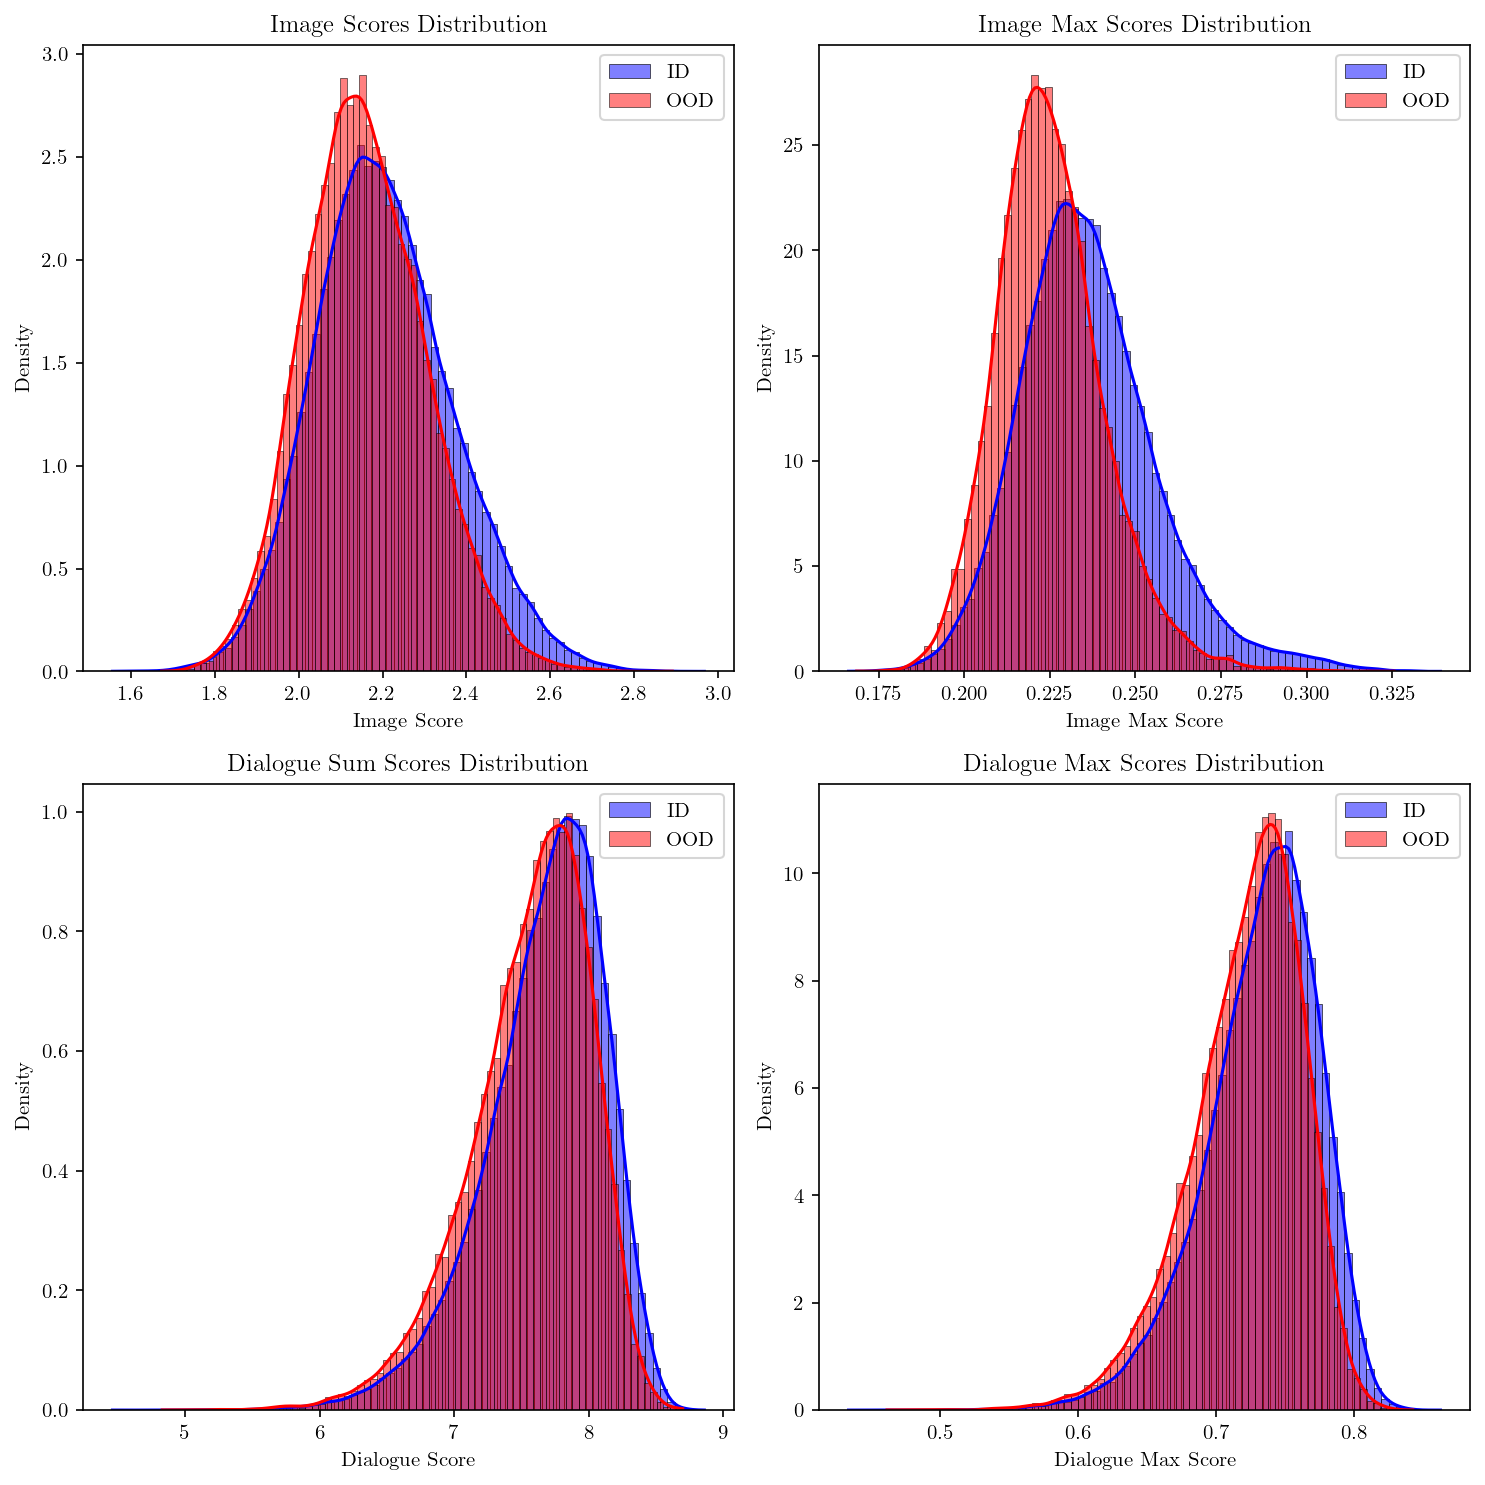

In [ ]:
from utils import plot_figure
import importlib
importlib.reload(plot_figure)

plot_figure.plot_cosine(df_table, save_fig = False, save_format = 'pdf', dpi = 300)

In [ ]:
def image_text_similarity(row):
    a = row['dialogue_clip']
    b = row['image_clip']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)
df_table['overall_simialrity'] = (df_table['image_score_max'] + df_table['dialogue_score_max'])
df_table['overall_simialrity_sum'] = (df_table['image_score'] + df_table['dialogue_score'])
df_table['overall_simialrity_transform'] = 4 * df_table['overall_simialrity'] * df_table['image_text_similarity']
df_table['overall_simialrity_transform_sum'] = 4 * df_table['overall_simialrity_sum'] * df_table['image_text_similarity']

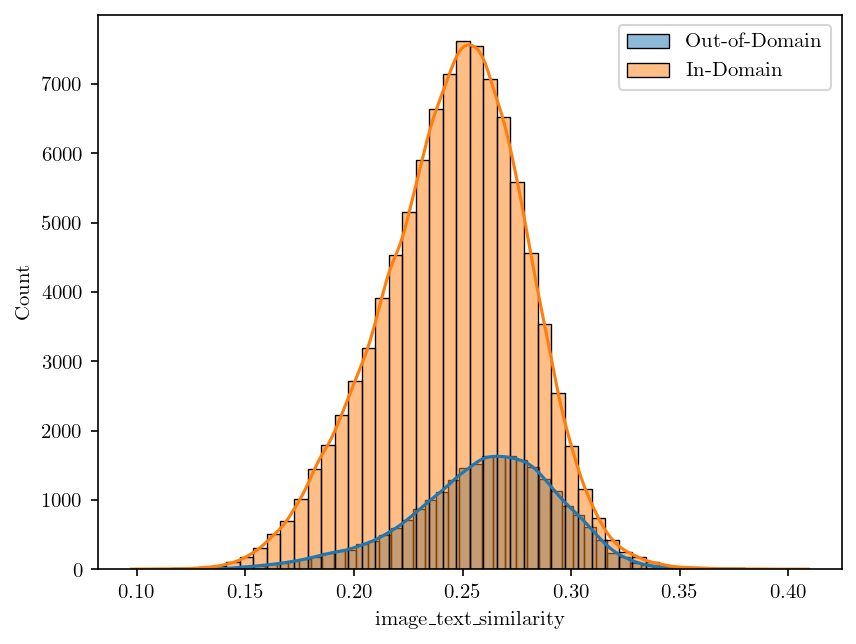

In [ ]:
sns.histplot(df_table[df_table['OOD'] == 0]['image_text_similarity'], bins=50, kde=True, label='Out-of-Domain')
sns.histplot(df_table[df_table['OOD'] == 1]['image_text_similarity'], bins=50, kde=True, label='In-Domain')
plt.legend()

In [ ]:
print('Image Max:', ev.fpr_evaluation(df_table['OOD'].values, df_table['image_score_max'].values, 0.95))
print('Image Sum:', ev.fpr_evaluation(df_table['OOD'].values, df_table['image_score'].values, 0.95))
print('Dialogue Max:', ev.fpr_evaluation(df_table['OOD'].values, df_table['dialogue_score_max'].values, 0.95))
print('Dialogue Sum:', ev.fpr_evaluation(df_table['OOD'].values, df_table['dialogue_score'].values, 0.95))
#print('Dialogue Segment Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment_max'].values, 0.95))
#print('Dialogue Segment Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment'].values, 0.95))
print("Overall Max:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity'].values, 0.95))
print("Overall Sum:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_sum'].values, 0.95))
print("Overall Transform Max:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_transform'].values, 0.95))
print("Overall Transform Sum:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_transform_sum'].values, 0.95))


Image Max: 0.8989802039592082
Image Sum: 0.9369726054789043
Dialogue Max: 0.9296940611877624
Dialogue Sum: 0.9308938212357528
Overall Max: 0.9092981403719256
Overall Sum: 0.9229754049190162
Overall Transform Max: 0.9674065186962607
Overall Transform Sum: 0.9679664067186563


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from models.DNN import model 

image_model_loader = model.model_loader(logger=logger,
                                  num_epochs=6,
                                  output_size=len(ind_category),
                                  learning_rate=0.001,
                                  proportion = 0.8,
                                  seed = 20)

dialogue_model_loader = model.model_loader(logger=logger,
                                    num_epochs=6,
                                    output_size=len(ind_category),
                                    learning_rate=0.001,
                                    seed = 20)

(
    df_ind_train, 
    df_test, 
    X_train_image, 
    X_test_image, 
    X_train_dialogue, 
    X_test_dialogue, 
    Y_train, 
    Y_test
) = image_model_loader.create_dataset(data_loader, df_table, add_mismatch = False, mismatch_num = 10000)

df_test['image_text_similarity'] = df_test.apply(image_text_similarity, axis=1)

2024-05-19 14:23:29,295 - notebook_logger - INFO - Setting random seed: 20
2024-05-19 14:23:29,309 - notebook_logger - INFO - Setting random seed: 20


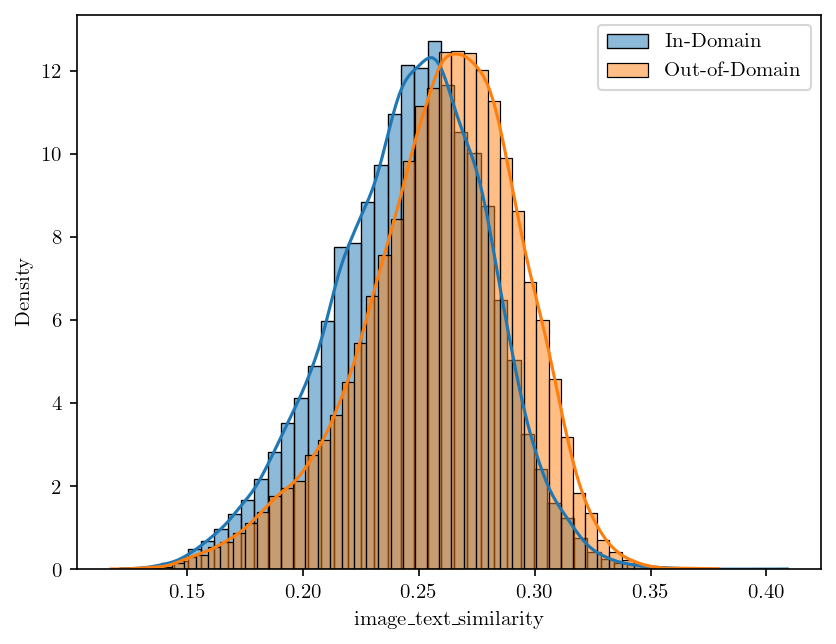

In [ ]:
sns.histplot(df_test[df_test['OOD'] == 1]['image_text_similarity'], kde=True, label='In-Domain', bins=50, stat='density')
sns.histplot(df_test[df_test['OOD'] == 0]['image_text_similarity'], kde=True, label='Out-of-Domain', bins=50, stat='density')
plt.legend()

In [ ]:
image_model_loader.train_model(X_train_image, Y_train, X_test_image, Y_test, ood_category = '_'.join(ood_category))

100%|██████████| 6/6 [00:33<00:00,  5.55s/it]
2024-05-19 14:24:14,705 - notebook_logger - INFO - Model saved at /Users/xuetongwu/Documents/GitHub/multimodal_ood/models/DNN/models/DNN/image_model_animal_6_0.001.pth


In [ ]:
dialogue_model_loader.train_model(X_train_dialogue, Y_train, X_test_dialogue, Y_test, ood_category = '_'.join(ood_category))

100%|██████████| 6/6 [00:30<00:00,  5.00s/it]
2024-05-19 14:24:44,867 - notebook_logger - INFO - Model saved at /Users/xuetongwu/Documents/GitHub/multimodal_ood/models/DNN/models/DNN/image_model_animal_6_0.001.pth


In [ ]:
score_type_list = ["prob", "energy", "logits", "msp"]

for score_type in score_type_list:
    image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    df_test[f'{score_type}_sum_image'] = image_score_sum
    df_test[f'{score_type}_max_image'] = image_score_max
    df_test[f'{score_type}_sum_dialogue'] = dialogue_score_sum
    df_test[f'{score_type}_max_dialogue'] = dialogue_score_max
    df_test[f'{score_type}_max_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_image'] 
    df_test[f'{score_type}_max_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_dialogue']
    df_test[f'{score_type}_sum_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_image']
    df_test[f'{score_type}_sum_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_dialogue']

    df_test[f'{score_type}_overall_simialrity_max'] = df_test[f'{score_type}_max_image'] + df_test[f'{score_type}_max_dialogue']
    df_test[f'{score_type}_overall_simialrity_max_transform'] =  df_test[f'{score_type}_max_image_tranform'] + df_test[f'{score_type}_max_dialogue_tranform']
    if score_type in ["energy", "logits", "prob"]:
        df_test[f'{score_type}_overall_simialrity_sum'] = df_test[f'{score_type}_sum_image'] + df_test[f'{score_type}_sum_dialogue']
        df_test[f'{score_type}_overall_simialrity_sum_transform'] = df_test[f'{score_type}_sum_image_tranform'] + df_test[f'{score_type}_sum_dialogue_tranform']

2024-05-19 14:24:45,234 - notebook_logger - INFO - Test Loss: 0.1863, Test Accuracy: 0.4457
2024-05-19 14:24:45,547 - notebook_logger - INFO - Test Loss: 0.2589, Test Accuracy: 0.3247
2024-05-19 14:24:45,872 - notebook_logger - INFO - Test Loss: 0.1863, Test Accuracy: 0.4457
2024-05-19 14:24:46,228 - notebook_logger - INFO - Test Loss: 0.2589, Test Accuracy: 0.3247
2024-05-19 14:24:46,563 - notebook_logger - INFO - Test Loss: 0.1863, Test Accuracy: 0.4457
2024-05-19 14:24:46,945 - notebook_logger - INFO - Test Loss: 0.2589, Test Accuracy: 0.3247
2024-05-19 14:24:47,267 - notebook_logger - INFO - Test Loss: 0.1863, Test Accuracy: 0.4457
2024-05-19 14:24:47,586 - notebook_logger - INFO - Test Loss: 0.2589, Test Accuracy: 0.3247


/Users/xuetongwu/Documents/GitHub/multimodal_ood/utils/plot_figure.py:86: SyntaxWarning: invalid escape sequence '\%'
  plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}')


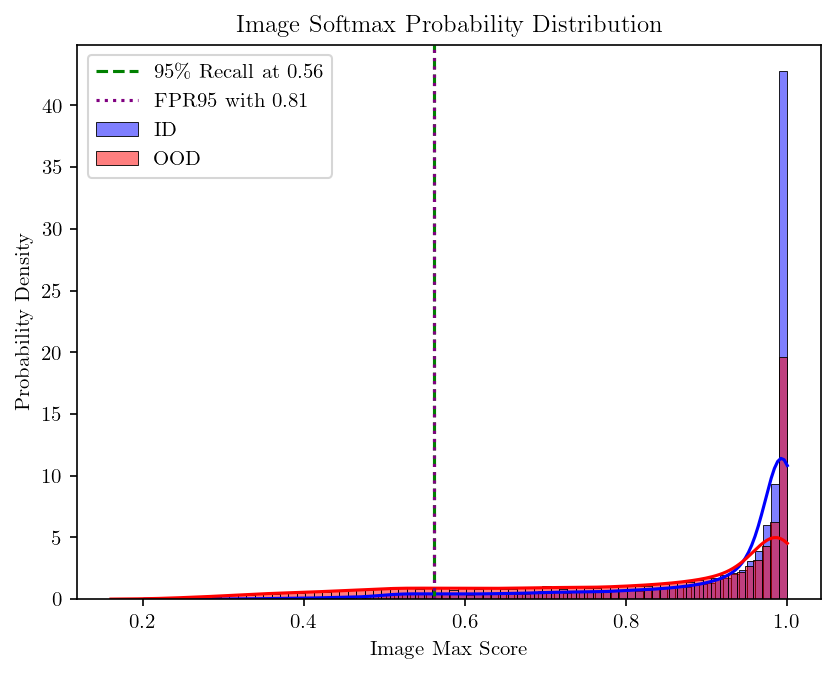

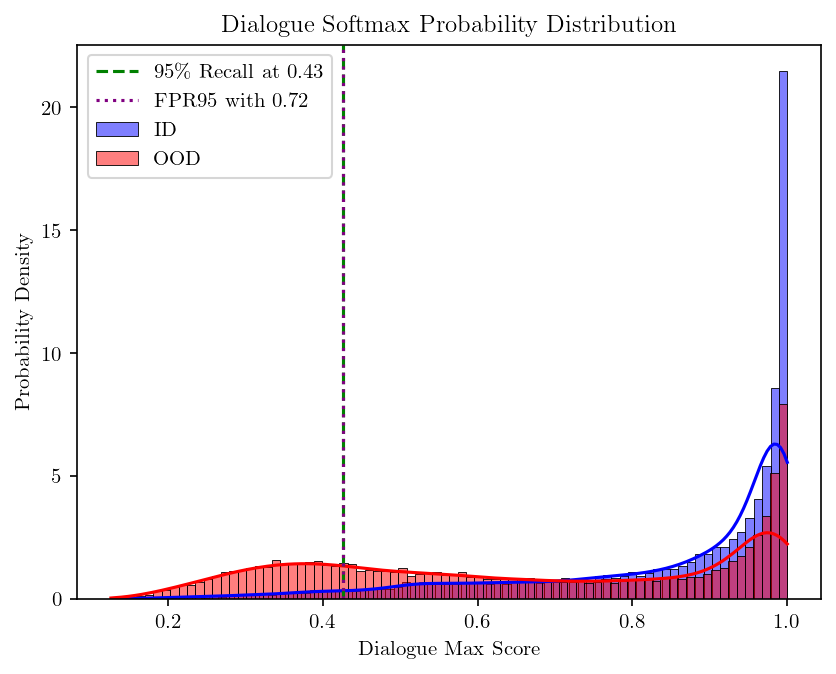

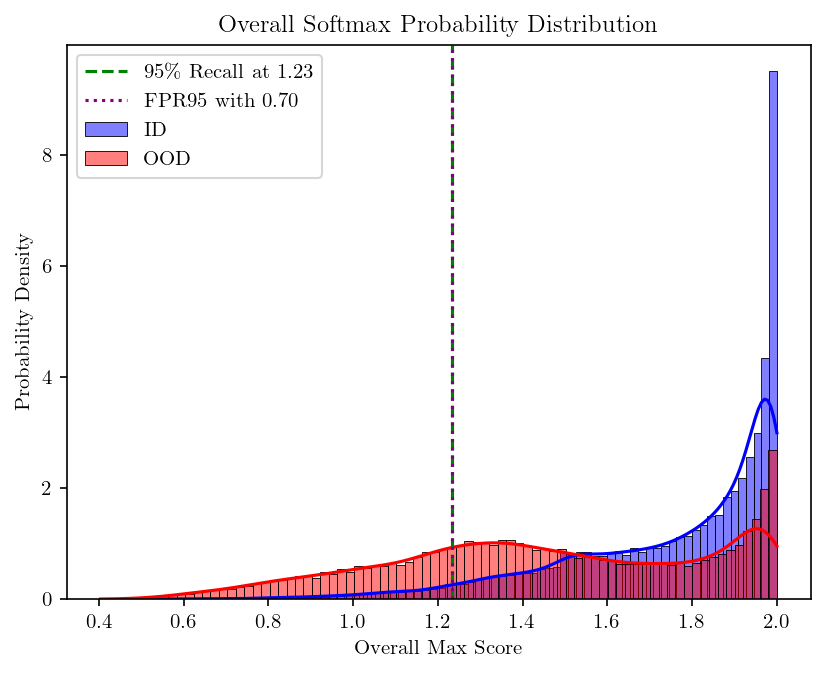

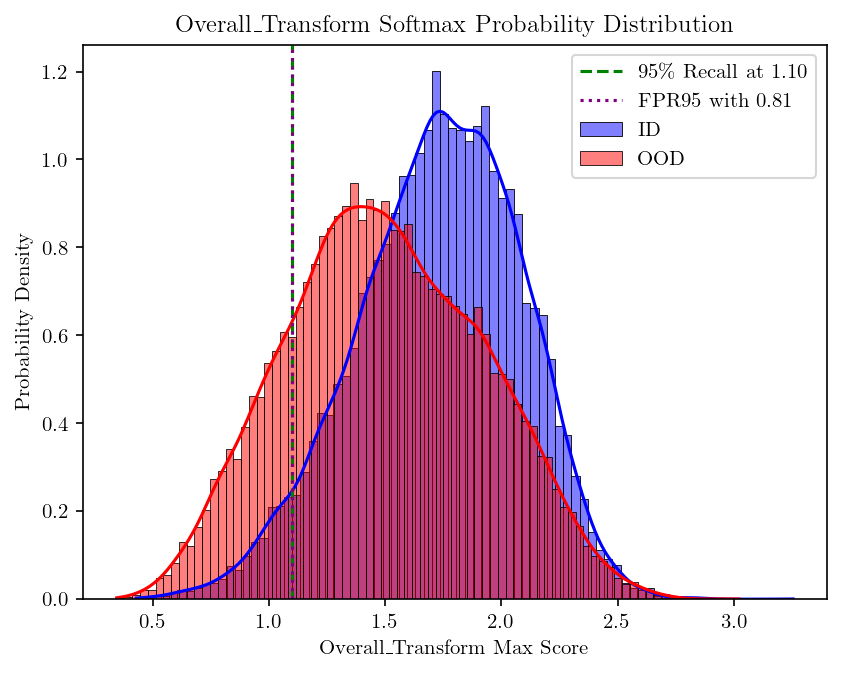

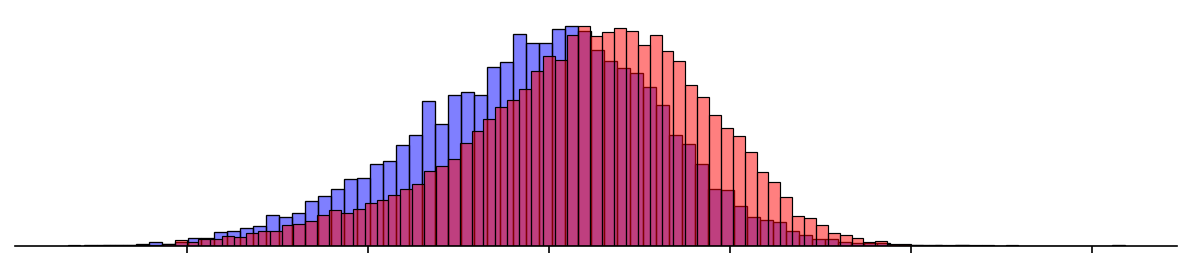

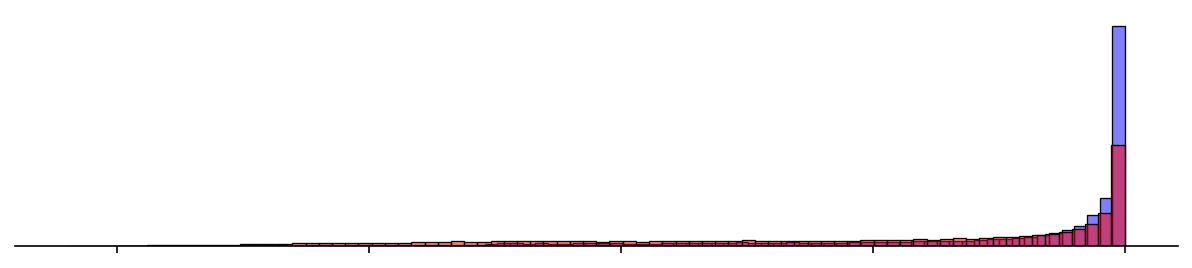

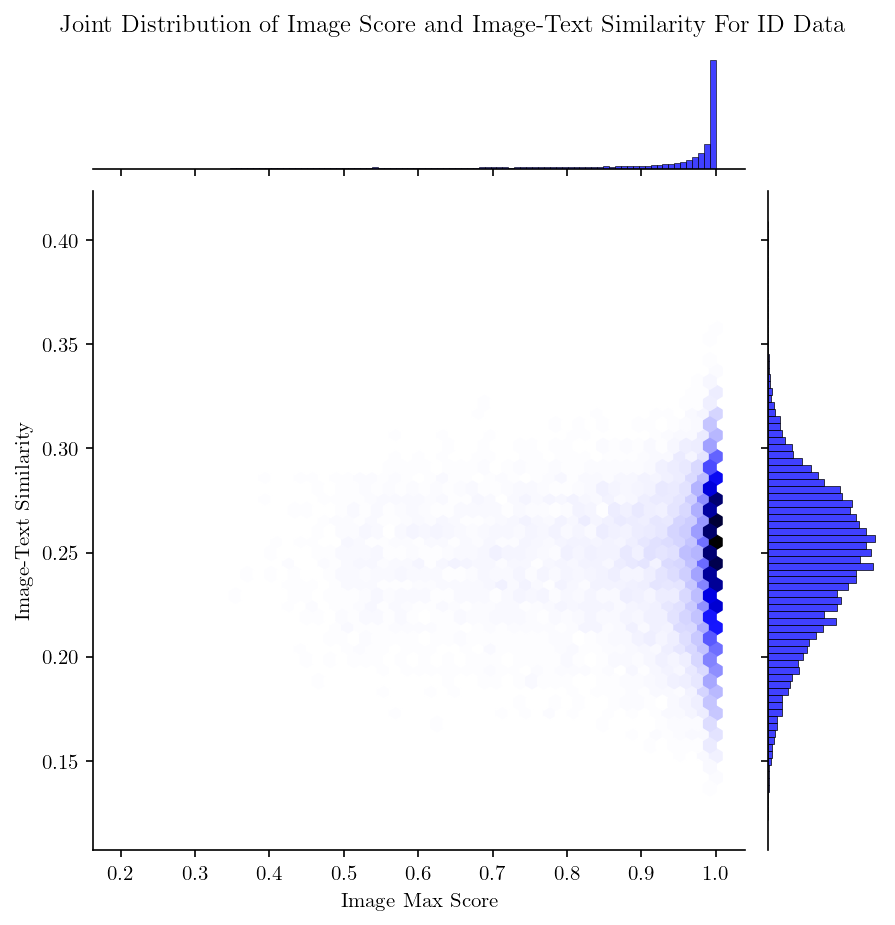

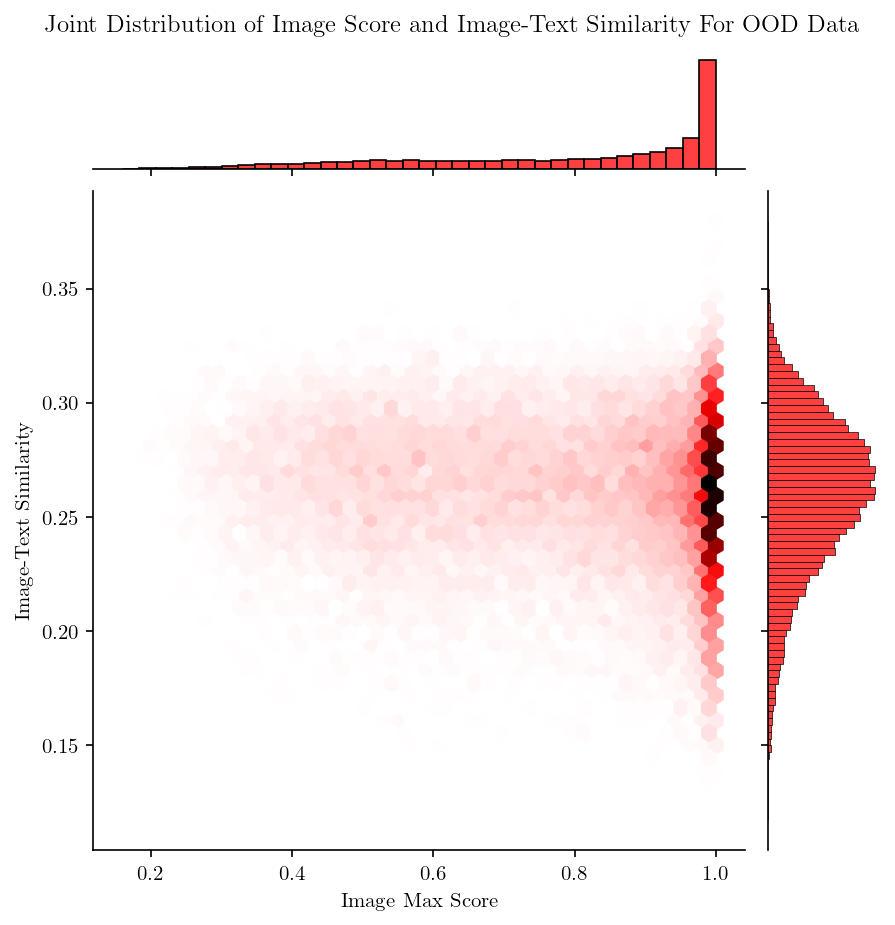

In [ ]:
import importlib
importlib.reload(plot_figure)

score_type = "msp"
type = "max"
mode = "image"
fpr = 95

plot_figure.plot_score_distribution(df_test, score_type, type, mode="image", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="dialogue", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="overall", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="overall_transform", fpr=fpr)
#plot_figure.plot_kde_joint_distribution(df_test, score_type, type, mode)
plot_figure.plot_rough_distribution(df_test, 'image_text_similarity')
plot_figure.plot_rough_distribution(df_test, f'{score_type}_{type}_{mode}')
plot_figure.plot_joint_distribution(df_test, score_type, type, mode, id = 1, color = 'blue')
plot_figure.plot_joint_distribution(df_test, score_type, type, mode, id = 0, color = 'red')

In [ ]:
# Initialize lists to store data
metrics = []
values = []
scores = [] 

def eval_dict(score):
    return {
        "FPR": lambda x: ev.fpr_evaluation(x['OOD'].values, x[score].values, 0.95),
        "AUROC": lambda x: ev.auroc_evaluation(x['OOD'].values, x[score].values),
        "AUPR": lambda x: ev.aupr_evaluation(x['OOD'].values, x[score].values)
    }

# Define the metrics and corresponding functions
metric_functions = {
    "Max Cosine": {
        "Image": eval_dict('image_score_max'),
        "Dialogue": eval_dict('dialogue_score_max'),
        "Overall": eval_dict('overall_simialrity'),
        "Overall_Transform": eval_dict('overall_simialrity_transform')
    },
    "Sum Cosine": {
        "Image": eval_dict('image_score'),
        "Dialogue": eval_dict('dialogue_score'),
        "Overall": eval_dict('overall_simialrity_sum'),
        "Overall_Transform": eval_dict('overall_simialrity_transform_sum')
    },
    "Energy Sum": {
        "Image": eval_dict('energy_sum_image'),
        "Dialogue": eval_dict('energy_sum_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('energy_overall_simialrity_sum_transform')
    },
    "Energy Max": {
        "Image": eval_dict('energy_max_image'),
        "Dialogue": eval_dict('energy_max_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_max'),
        "Overall_Transform": eval_dict('energy_overall_simialrity_max_transform')
    },
    "MSP": {
        "Image": eval_dict('msp_max_image'),
        "Dialogue": eval_dict('msp_max_dialogue'),
        "Overall": eval_dict('msp_overall_simialrity_max'),
        "Overall_Transform": eval_dict('msp_overall_simialrity_max_transform')
    },
    "Max Prob": {
        "Image": eval_dict('mp_max_image'),
        "Dialogue": eval_dict('mp_max_dialogue'),
        "Overall": eval_dict('mp_overall_simialrity_max'),
        "Overall_Transform": eval_dict('mp_overall_simialrity_max_transform')
    },
    "Max Logits": {
        "Image": eval_dict('logits_max_image'),
        "Dialogue": eval_dict('logits_max_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_max'),
        "Overall_Transform": eval_dict('logits_overall_simialrity_max_transform')
    },
    "Sum Logits": {
        "Image": eval_dict('logits_sum_image'),
        "Dialogue": eval_dict('logits_sum_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('logits_overall_simialrity_sum_transform')
    }
}

# Loop through each metric and calculate values
for score, items in metric_functions.items():
    scores.extend([score] * len(items) * 3)
    for metric, funcs in items.items():
        metrics.extend([metric] * len(funcs))
        values.extend([func(df_test) for func in funcs.values()])

# Create DataFrame
df = pd.DataFrame({"Metric": metrics, "Value": values, "Score": scores})
df['Value'] = df['Value'].apply(lambda x: round(x, 3))
#df_grouped = df.groupby('Metric')['Value'].apply(list).reset_index()
result = df.groupby(['Metric', 'Score'])['Value'].agg(list).unstack().transpose()
result_df = result[['Image', 'Dialogue', 'Overall', 'Overall_Transform']]
result_df.reset_index(inplace=True)
order = ['Max Cosine', 'Sum Cosine', 'Energy Sum', 'Energy Max', 'MSP', 'Max Prob', 'Max Logits', 'Sum Logits']
result_df = result_df.set_index('Score').loc[order].reset_index()

In [ ]:
def convert_to_percentage(lst):
    return ' / '.join(f'{x*100:.1f}' for x in lst)

result_df['Image'] = result_df['Image'].apply(convert_to_percentage)
result_df['Dialogue'] = result_df['Dialogue'].apply(convert_to_percentage)
result_df['Overall'] = result_df['Overall'].apply(convert_to_percentage)
result_df['Overall_Transform'] = result_df['Overall_Transform'].apply(convert_to_percentage)

latex_table = result_df.to_latex(index=False, column_format='|l|c|c|c|c|', header=["Score", "Image", "Dialogue", "Overall", "Overall_Transform"], escape=False)

print(latex_table)

\begin{tabular}{|l|c|c|c|c|}
\toprule
Score & Image & Dialogue & Overall & Overall_Transform \\
\midrule
Max Cosine & 90.1 / 66.9 / 61.7 & 93.0 / 58.0 / 52.8 & 91.0 / 63.1 / 59.3 & 96.7 / 42.8 / 40.1 \\
Sum Cosine & 93.7 / 57.8 / 52.7 & 93.2 / 57.3 / 51.4 & 92.6 / 59.1 / 53.8 & 96.7 / 41.1 / 38.5 \\
Energy Sum & 47.4 / 83.4 / 77.6 & 58.6 / 81.0 / 76.1 & 45.7 / 84.7 / 80.2 & 47.6 / 83.5 / 77.8 \\
Energy Max & 49.7 / 83.1 / 77.4 & 59.9 / 80.4 / 74.6 & 46.7 / 84.9 / 80.3 & 48.7 / 83.3 / 77.4 \\
MSP & 81.2 / 69.0 / 62.9 & 71.4 / 71.6 / 63.4 & 69.4 / 74.6 / 66.4 & 81.4 / 66.2 / 54.7 \\
Max Prob & 49.7 / 83.1 / 77.4 & 59.9 / 80.4 / 74.6 & 46.6 / 84.3 / 79.0 & 64.4 / 72.5 / 58.8 \\
Max Logits & 49.7 / 83.1 / 77.4 & 59.9 / 80.4 / 74.6 & 45.7 / 85.0 / 80.4 & 47.6 / 83.6 / 77.6 \\
Sum Logits & 90.1 / 62.0 / 55.2 & 99.7 / 42.3 / 44.2 & 98.1 / 56.1 / 52.4 & 96.2 / 59.0 / 54.3 \\
\bottomrule
\end{tabular}



In [ ]:
def calculate_class_stats(model, train_loader):
    model.eval()
    class_means = []
    class_covariances = []
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in train_loader:
            data = data.cuda()
            features = model(data)
            all_features.append(features.cpu().numpy())
            all_labels.append(target.numpy())
    
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    for label in np.unique(all_labels):
        class_features = all_features[all_labels == label]
        class_mean = np.mean(class_features, axis=0)
        class_cov = np.cov(class_features, rowvar=False)
        class_means.append(class_mean)
        class_covariances.append(class_cov)
    
    return class_means, class_covariances

def mahalanobis_distance(x, mean, cov):
    x_minus_mean = x - mean
    inv_cov = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mean, inv_cov)
    mahalanobis_dist = np.sqrt(np.dot(left_term, x_minus_mean.T))
    return mahalanobis_dist

def calculate_ood_scores(model, test_loader, class_means, class_covariances):
    model.eval()
    ood_scores = []
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            features = model(data).cpu().numpy()
            
            for feature in features:
                min_distance = float('inf')
                for mean, cov in zip(class_means, class_covariances):
                    distance = mahalanobis_distance(feature, mean, cov)
                    if distance < min_distance:
                        min_distance = distance
                ood_scores.append(min_distance)
    
    return np.array(ood_scores)


## Results on OOD

# Without Mismatching Pair, Test ID instance 23233, Test OOD instance 6051


## Without image text similarity score
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.32, 0.952, 0.988]  |
| Energy Sum | [0.236, 0.964, 0.991] | [0.508, 0.935, 0.984] | [0.151, 0.974, 0.994] |
| MSP        | [0.894, 0.625, 0.873] | [0.919, 0.68, 0.905]  | [0.885, 0.657, 0.889] |
| Max Cosine | [0.877, 0.711, 0.905] | [0.971, 0.54, 0.835]  | [0.964, 0.579, 0.857] |
| Max Logits | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.331, 0.951, 0.988] |
| Max Prob   | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.507, 0.927, 0.982] |
| Sum Cosine | [0.94, 0.576, 0.84]   | [0.978, 0.494, 0.814] | [0.972, 0.51, 0.817]  |
| Sum Logits | [0.904, 0.762, 0.934] | [0.974, 0.758, 0.931] | [0.932, 0.788, 0.943] |

## With image text similarity score overall
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.346, 0.945, 0.986] |
| Energy Sum | [0.236, 0.964, 0.991] | [0.508, 0.935, 0.984] | [0.194, 0.97, 0.993]  |
| MSP        | [0.894, 0.625, 0.873] | [0.919, 0.68, 0.905]  | [0.908, 0.574, 0.846] |
| Max Cosine | [0.877, 0.711, 0.905] | [0.971, 0.54, 0.835]  | [0.964, 0.579, 0.857] |
| Max Logits | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.35, 0.945, 0.986]  |
| Max Prob   | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.731, 0.793, 0.934] |
| Sum Cosine | [0.94, 0.576, 0.84]   | [0.978, 0.494, 0.814] | [0.972, 0.51, 0.817]  |
| Sum Logits | [0.904, 0.762, 0.934] | [0.974, 0.758, 0.931] | [0.955, 0.764, 0.934] |

# With 5000 mismatching pairs, testing ID instance 23233, test OOD isntance 11051


## Without image text similarity
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.614, 0.758, 0.838] |
| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.522, 0.767, 0.843] |
| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.921, 0.598, 0.773] |
| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |
| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.619, 0.758, 0.839] |
| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.707, 0.765, 0.848] |
| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |
| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.953, 0.672, 0.814] |

## With imge text similarity score on overall 
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.598, 0.862, 0.932] |
| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.511, 0.872, 0.934] |
| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.752, 0.723, 0.831] |
| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |
| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.607, 0.86, 0.931]  |
| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.569, 0.859, 0.924] |
| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |
| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.975, 0.546, 0.709] |






